In [5]:
import sys


In [8]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [9]:
#TF Version
tf.__version__

'1.6.0'

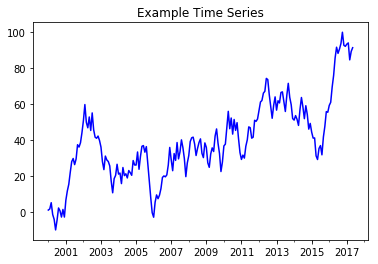

2000-01-31    1.076620
2000-02-29    1.694514
2000-03-31    5.165528
2000-04-30   -1.387576
2000-05-31   -4.046432
2000-06-30   -9.936538
2000-07-31   -4.456382
2000-08-31    2.236906
2000-09-30    0.668546
2000-10-31   -2.792224
Freq: M, dtype: float64

In [12]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

In [22]:
TS = np.array(ts)
num_periods = 200
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 200, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 200, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

1
(1, 200, 1)
[[[ 1.07661981]
  [ 1.69451424]
  [ 5.16552807]
  [-1.38757589]
  [-4.04643229]
  [-9.93653803]
  [-4.45638236]
  [ 2.23690645]
  [ 0.6685456 ]
  [-2.79222397]
  [ 1.41607686]
  [-2.79680603]
  [ 6.52501364]
  [11.66056061]
  [15.3732239 ]
  [21.98171924]
  [27.97311486]
  [29.71006806]
  [26.31043426]
  [29.42947618]
  [37.36615225]
  [36.05734782]
  [38.45301017]
  [44.02558732]
  [50.74182922]
  [59.65085363]
  [49.78446845]
  [46.75133067]
  [52.76122814]
  [45.26981392]
  [55.00770886]
  [45.67489203]
  [41.53151349]
  [40.94149463]
  [42.1575685 ]
  [39.7273796 ]
  [36.04459333]
  [28.00281706]
  [23.5314251 ]
  [31.05159653]
  [28.90427247]
  [28.03892291]
  [25.59553648]
  [17.12658897]
  [10.66879311]
  [18.51027621]
  [20.33803054]
  [26.50400087]
  [21.04462518]
  [21.61862125]
  [15.77280097]
  [24.70508438]
  [20.20939219]
  [21.23107112]
  [18.90660534]
  [23.02515652]
  [21.85051873]
  [20.37915438]
  [28.56731409]
  [26.10753083]
  [26.0636434 ]
  [33.3254

In [24]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 200, 1)
    testY = TS[-(num_periods):].reshape(-1, 200, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 200, 1)
[[[ 0.6685456 ]
  [-2.79222397]
  [ 1.41607686]
  [-2.79680603]
  [ 6.52501364]
  [11.66056061]
  [15.3732239 ]
  [21.98171924]
  [27.97311486]
  [29.71006806]
  [26.31043426]
  [29.42947618]
  [37.36615225]
  [36.05734782]
  [38.45301017]
  [44.02558732]
  [50.74182922]
  [59.65085363]
  [49.78446845]
  [46.75133067]
  [52.76122814]
  [45.26981392]
  [55.00770886]
  [45.67489203]
  [41.53151349]
  [40.94149463]
  [42.1575685 ]
  [39.7273796 ]
  [36.04459333]
  [28.00281706]
  [23.5314251 ]
  [31.05159653]
  [28.90427247]
  [28.03892291]
  [25.59553648]
  [17.12658897]
  [10.66879311]
  [18.51027621]
  [20.33803054]
  [26.50400087]
  [21.04462518]
  [21.61862125]
  [15.77280097]
  [24.70508438]
  [20.20939219]
  [21.23107112]
  [18.90660534]
  [23.02515652]
  [21.85051873]
  [20.37915438]
  [28.56731409]
  [26.10753083]
  [26.0636434 ]
  [33.32540599]
  [23.72677335]
  [30.9369004 ]
  [36.50248917]
  [36.88218212]
  [33.214471  ]
  [36.29568082]
  [26.79966946]
  [17.778352

In [25]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 200      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer() 

In [26]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 220892.3


100 	MSE: 6711.59


200 	MSE: 5184.1606


300 	MSE: 4063.9307


400 	MSE: 2960.9556


500 	MSE: 1711.501


600 	MSE: 1147.0695


700 	MSE: 749.457


800 	MSE: 459.23093


900 	MSE: 665.46265


[[[  0.6464789]
  [ -2.5094302]
  [  0.3752185]
  [ -2.9249003]
  [  5.610011 ]
  [ 10.074859 ]
  [ 12.684781 ]
  [ 18.803822 ]
  [ 24.545975 ]
  [ 29.713007 ]
  [ 30.324959 ]
  [ 31.575945 ]
  [ 39.592667 ]
  [ 41.381382 ]
  [ 41.55916  ]
  [ 47.30246  ]
  [ 51.798985 ]
  [ 58.867615 ]
  [ 53.05945  ]
  [ 48.139755 ]
  [ 47.43     ]
  [ 48.534424 ]
  [ 48.75782  ]
  [ 44.212173 ]
  [ 48.799988 ]
  [ 45.26469  ]
  [ 38.76784  ]
  [ 33.091927 ]
  [ 29.432457 ]
  [ 25.829058 ]
  [ 26.966515 ]
  [ 31.35743  ]
  [ 32.31931  ]
  [ 32.53016  ]
  [ 21.522175 ]
  [ 10.773455 ]
  [ 17.901573 ]
  [ 24.220753 ]
  [ 26.84823  ]
  [ 22.779741 ]
  [ 21.911074 ]
  [ 12.069411 ]
  [ 26.466282 ]
  [ 20.707106 ]
  [ 20.753555 ]
  [ 15.145437 ]
  [ 19.836882 ]
  [ 29.761055 ]
  [ 24.134464 ]
  [ 23.1833   ]
  [ 25.35814  ]
  [ 27.13451  ]
  [ 27.67136  ]
  [ 26.242838 ]
  [ 25.758087 ]
  [ 35.34578  ]
  [ 33.20404  ]
  [ 33.338005 ]
  [ 31.616274 ]
  [ 30.164068 ]
  [ 25.935768 ]
  [ 15.2327   ]
  [  5.0

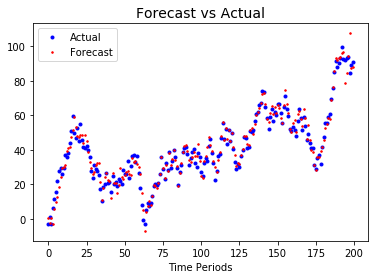

In [31]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=3, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=3, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()